In [1]:
from math import log
import operator
import matplotlib.pyplot as plt
import pickle

In [2]:
def shannonEntropy(dataset):
    n = len(dataset)
    labelCounts = {}
    for feature in dataset:
        curr_label = feature[-1]
        labelCounts[curr_label] = labelCounts.get(curr_label, 0) + 1
    entropy = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / n
        if prob > 0:
            entropy -= prob * log(prob, 2)
    return entropy

In [3]:
def splitDataset(dataset, axis, value):
    return_dataset = []
    for feature in dataset:
        if feature[axis] == value:
            reduced_feature = feature[:axis]
            reduced_feature.extend(feature[axis+1:])
            return_dataset.append(reduced_feature)
    return return_dataset        

In [4]:
def chooseBestFeatureForSplit(dataset):
    n = len(dataset[0]) - 1
    base_entropy = shannonEntropy(dataset)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(n):
        feature_list = [j[i] for j in dataset]
        unique_vals = set(feature_list)
        new_entropy = 0.0
        for val in unique_vals:
            sub_dataset = splitDataset(dataset, i, val)
            prob = len(sub_dataset)/float(len(dataset))
            new_entropy += prob* shannonEntropy(sub_dataset)
        info_gain = base_entropy - new_entropy
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    return best_feature            

In [5]:
def majority_count(classList):
    classCount = {}
    for vote in classList:
        classCount[vote] = classCount.get(vote,0) + 1
    sortedClassCount = sorted(classCount.items(), key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

In [6]:
def createTree(dataset, labels):
    classList = [j[-1] for j in dataset]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataset[0]) == 1:
        return majority_count(classList)
    best_feature= chooseBestFeatureForSplit(dataset)
    best_feature_label = labels[best_feature]
    my_tree = {best_feature_label: {}}
    del(labels[best_feature])
    feature_values = [j[best_feature] for j in dataset]
    unique = set(feature_values)
    for value in unique:
        sub_labels = labels[:]
        my_tree[best_feature_label][value] = createTree(splitDataset(dataset,best_feature, value), sub_labels)
    return my_tree
    

In [7]:
def createplot(tree):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")
    leafNode = dict(boxstyle="round4", fc="0.8")
    arrow_args = dict(arrowstyle="<-")

    def plotMidText(cntrPt, parentPt, txt):
        xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
        yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
        createplot.ax1.text(xMid, yMid + 0.01, txt, fontsize=10, va="center", ha="center")

    def plotNode(nodeTxt, centerPt, parentPt, nodeType):
        createplot.ax1.annotate(
            nodeTxt,
            xy=parentPt,
            xycoords='axes fraction',
            xytext=centerPt,
            textcoords='axes fraction',
            va='center',
            ha='center',
            bbox=nodeType,
            arrowprops=arrow_args,
            fontsize=13
        )

    def getNumLeafs(tree):
        num_leafs = 0
        first_str = list(tree.keys())[0]
        second_dict = tree[first_str]
        for key in second_dict.keys():
            if isinstance(second_dict[key], dict):
                num_leafs += getNumLeafs(second_dict[key])
            else:
                num_leafs += 1
        return num_leafs

    def getTreeDepth(tree):
        max_depth = 0
        first_str = list(tree.keys())[0]
        second_dict = tree[first_str]
        for key in second_dict.keys():
            if isinstance(second_dict[key], dict):
                this_depth = 1 + getTreeDepth(second_dict[key])
            else:
                this_depth = 1
            max_depth = max(max_depth, this_depth)
        return max_depth

    def plotTree(tree, parentPt, nodeTxt):
        numLeafs = getNumLeafs(tree)
        firstStr = list(tree.keys())[0]
        cntrPt = (
            plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW,
            plotTree.yOff
        )
        plotMidText(cntrPt, parentPt, nodeTxt)
        plotNode(firstStr, cntrPt, parentPt, decisionNode)
        secondDict = tree[firstStr]
        plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
        for key in secondDict.keys():
            if isinstance(secondDict[key], dict):
                plotTree(secondDict[key], cntrPt, str(key))
            else:
                plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
                plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
                plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
        plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

    fig = plt.figure(1, facecolor='white', figsize=(14, 10))
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createplot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(tree))
    plotTree.totalD = float(getTreeDepth(tree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(tree, (0.5, 1.0), '')
    plt.tight_layout()
    plt.show()

In [8]:
def classify(tree, labels, test_vector):
    first_str = list(tree.keys())[0]
    second_dict = tree[first_str]
    ind = labels.index(first_str)
    for key in second_dict.keys():
        if test_vector[ind] == key:
            if type(second_dict[key]).__name__ == 'dict':
                class_label = classify(second_dict[key], labels, test_vector)
            else:
                class_label = second_dict[key]
    return class_label
    

In [9]:
def storeTree(tree, filename):
    fw = open(filename, 'wb')
    pickle.dump(tree, fw)
    fw.close()

In [10]:
def loadTree(filename):
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [11]:
fr = open('lenses.txt')
lenses = [inst.strip().split("\t") for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']

In [12]:
my_tree = createTree(lenses, lensesLabels[:])

In [13]:
my_tree

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'no': {'age': {'young': 'soft',
      'pre': 'soft',
      'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}},
    'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'young': 'hard',
        'pre': 'no lenses',
        'presbyopic': 'no lenses'}}}}}}}}

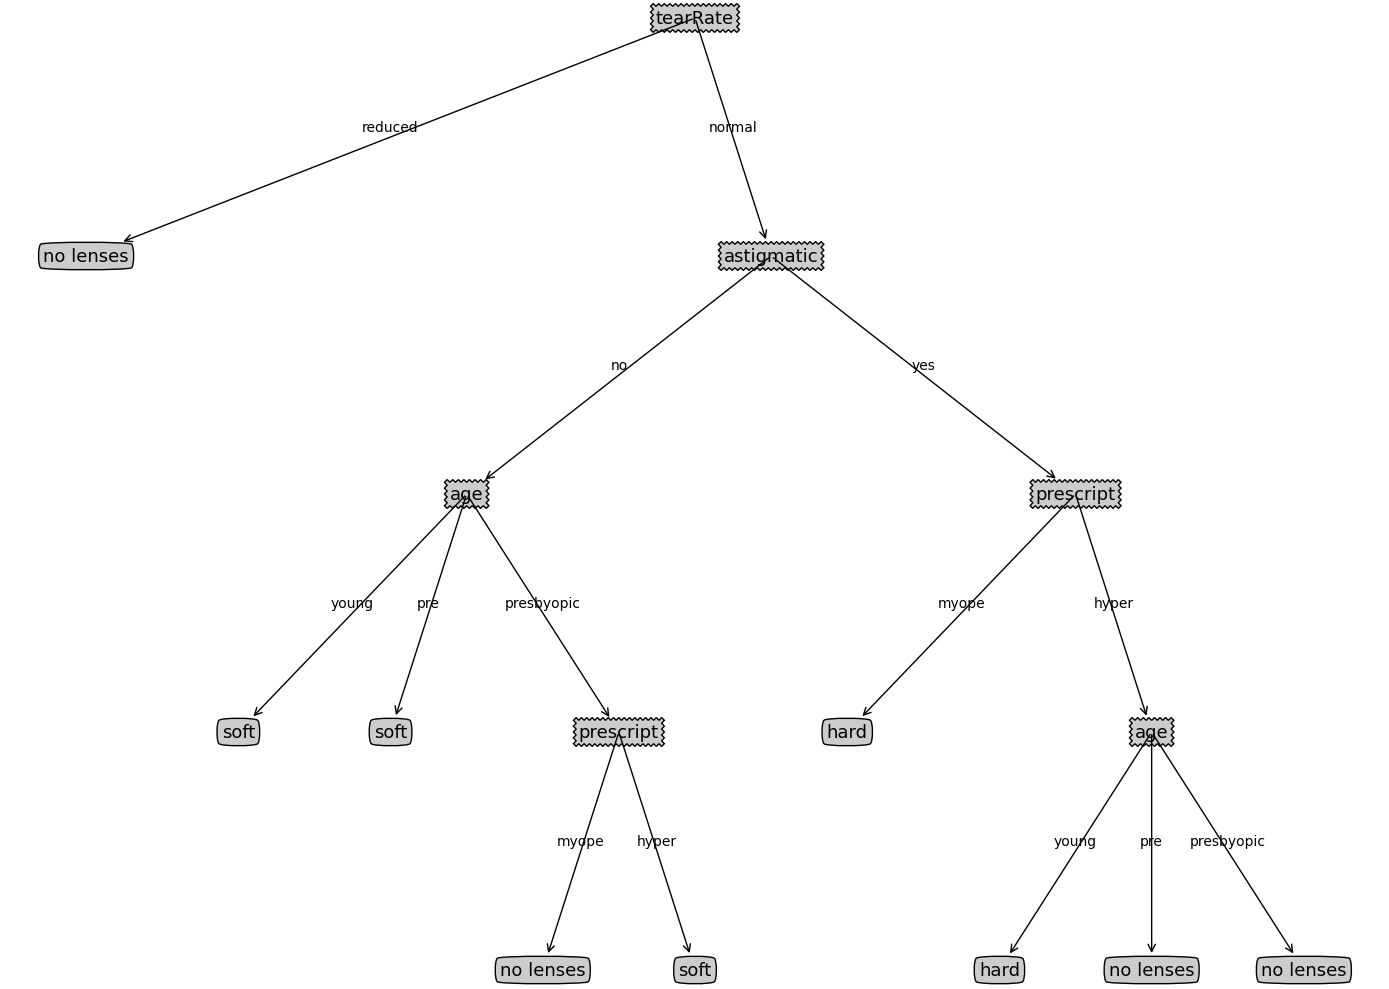

In [14]:
createplot(my_tree)

In [15]:
classify(my_tree, lensesLabels, ['presbyopic','myope','yes', 'normal'])

'hard'

In [16]:
classify(my_tree, lensesLabels, ['presbyopic','hyper','yes', 'normal'])

'no lenses'

In [17]:
classify(my_tree, lensesLabels, ['young','myope','no', 'reduced'])

'no lenses'

In [18]:
classify(my_tree, lensesLabels, ['pre','hyper','no', 'normal'])

'soft'

In [19]:
storeTree(my_tree, 'LenseTree.txt')